# Modeling and Simulation in Python

Project 1

Leatherback Sea Turtles Nesting Mother Population

Kyle McCracken and David Tarazi

# Question to answer: 
### Does the population growth pattern work the same in the Northern Caribbean beaches as it does on St. Croix?

We can try to answer this by modeling St. Croix's leatherback turtle population and then applying that model to the data gathered from Northern Carribean beaches. We hypothesize that the growth rate should be very similar given that the species of turtle is the same and the location is relatively close, despite the larger starting population in the Northern Caribbean.

Model:
Parameters/Data
* US Virgin Island Data:
        Yearly nesting females, How many turtles returned after 1,2,3... years
* Data we need to parameterize:
        population proxy, proxy for probability of return after 1,2,3... years, rate of new turtles nesting

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

from modsim import *

from pandas import *

### Implementing System and State Objects and Reading our Data
To create easy reference for probabilities and actual population values in certain years

In [5]:
system = System(nestR = .002, #tuned rates for returning turtles after x years :)
                rr1 = .01, 
                rr2 = .59, 
                rr3 = .28, 
                rr4 = .16, 
                rr5 = .047, 
                rr6 = .015,
                startYear = 1983, 
                endYear = 2020,
                startPop = 23)
state = State(population = 2000, #estimated starting population; could be used to add birth/death rates in future
              r1T = TimeSeries(), #Stores the number of turtles that return after x year in each year
              r2T = TimeSeries(), 
              r3T = TimeSeries(), 
              r4T = TimeSeries(), 
              r5T = TimeSeries(), 
              r6T = TimeSeries(), #use 6 years based on the return intervals in the data
              newN = TimeSeries()) #Stores the number of new nesters each year

In [6]:
turtleDataframe = pandas.read_csv('data/Garner_LeatherbackRemigrationIntervalsData_StCroix.csv',index_col = 0, header = 0) #reads data
nestingTurtleData = turtleDataframe['Turtles'] #creates dataframe
"""
parses dataframe and creates a list of values for number of returning turtles after x years 
every year that corresponds to the year in which that data was collected
"""
ri1 = turtleDataframe['RI1']
ri2 = turtleDataframe['RI2']
ri3 = turtleDataframe['RI3']
ri4 = turtleDataframe['RI4']
ri5 = turtleDataframe['RI5'] 
ri6 = turtleDataframe['RI6up'] #any turtles returning from 6+ years ago
new = turtleDataframe['Unknown'] #new nesters

### Step function to update the number of new nesters each year and simulation runner
In the step function we take in the new nesters which in the beginning we make much larger to simulate the lost data from turtles returning in the previous years we are not modeling.We then adjust after the first two years to having the new nesters based off of a rate and the population proxy we tuned.

We fill the state's TimeSeries for the turtles returning every year, every two years and so on based on the population from the year they were returning from multiplied by a specific tuned rate we estimated to fit St. Croix's data

The R6up if else essentially averages the population from the beginning of the model up to 6 years prior to the year we are simulating and then multiplying by a rate to identify the returning turtles from any year more than 6 years ago.

We use 6 years because the data we found gave us return intervals of 1,2,3,4,5, and 6 or more years.

In [7]:
def stepmk1(system, state, t, fiveYearPop, sixAndBefore, sabAge):
    """This function updates and returns the number of nesters arriving on the beach to give lay eggs in any given year 
    using the return rates from the last 5 years assuming they have data and every year prior to that even"""
    if t < int(system.startYear) + 2:  #for the first two years, we want a solid base of new nesters
        newNesters = system.startPop
    else:
        newNesters = system.nestR * state.population  #new nesters arriving this year based on a tuned rate and current population
    state.newN[t] = newNesters

    R1 = fiveYearPop[1] * system.rr1    #fiveYearPop = the population from the previous 5 years 
                                        #i.e. fiveYearPop[1] is the population 1 year ago
    state.r1T[t] = R1                         #fills the system's Timeseries for return numbers every x years for each year
    R2 = fiveYearPop[2] * system.rr2
    state.r2T[t] = R2
    R3 = fiveYearPop[3] * system.rr3
    state.r3T[t] = R3
    R4 = fiveYearPop[4] * system.rr4
    state.r4T[t] = R4
    R5 = fiveYearPop[5] * system.rr5
    state.r5T[t] = R5
    if t > int(system.startYear) + 5:       #once we have 6 years of data we can include the tuned rate from 6 years ago and before
        R6up = (sixAndBefore / sabAge) * system.rr6     #sixAndBefore/sabAge is the average population from the beginning of the model
    else:
        R6up = 0
    state.r6T[t] = R6up

    nesters = newNesters + R1 + R2 + R3 + R4 + R5 + R6up       #sums all the nesters added this year
    return nesters      #returns the number of nesters this year

# Running the Simulation
When running the simulation, we temporarily fill fiveYearPop which is a TimeSeries that allows us to store the population from the 5 years prior to the year we are currently simulating so that we don't run into empty values in the step function

We then count the number of years we have been running the simulation for (sabAge) so that we can aaverage the population up to 6 years prior to the year we are simulating in the step function. We also add population to sixAndBefore to sum the population from the start of the model

We use begC to account for the first 5 years when we don't have turtles returning from some number of years before the model has reached that point. This allows us to only account for turtles returning up to two years ago when we have only been simulating for two years

Finally, we run the step function to model the number of nesting females and returning the TimeSeries, results, which holds them

In [8]:
def runSimulation(system,state,step):
    results = TimeSeries()  #Stores nesting population
    fiveYearPop = TimeSeries() #Temporarily stores the population for the last five years for each step

    for n1 in range(1,6): #Fills fiveYearPop temporary values before they can be set
        fiveYearPop[n1] = 0

    for t in range(int(system.startYear),int(system.endYear)):  #Once we have six years of data this sums the population of every year six years before t and earlier
        if t <= int(system.startYear) + 5:
            sixAndBefore = 0
            sabAge = 1 #Not 0 to avoid dividing by 0 in stop
        else:
            sabAge = t - int(system.startYear) - 5 #Give number of years that have happened since start of mdel until 6 years prior
            for s in range (int(system.startYear),t-5):
                sixAndBefore = sixAndBefore + results[s]    #Adds populaiton from the last year to the total population from start of model

        if t <= int(system.startYear) + 4:   #Prevents fiveYearPop from receiving population data from years that weren't simulated
            begC = (t - int(system.startYear)) + 1
        else:
            begC = 6    #begC is a counter to define range for the loop below

        if t != int(system.startYear):   #Stores population data in fiveYearPop as long as it's not the first year of simulation
            for p in range(1,begC):
                fiveYearPop[p] = results[t-p]   #Fills fiveYearPop in reverse so that the first instance is 1 year ago, etc.
                
        #Runs step functions, calculating nesting population based on previous year populations
        results[t] = step(system,state,t, fiveYearPop, sixAndBefore, sabAge) 
    return results

### Plotting!

In [9]:
def plotResults(turtleData, timeseries, title, colorin):    #Plotting function for any series against some form of data
    plot(turtleData, '--', label='Nesting Data')
    plot(timeseries, color=colorin, label='model')

    decorate(xlabel='Year',
             ylabel='Nesting Population',
             title=title)

### Plotting the St. Croix Nesting Population
plots results against the total nesting population collected from St. Croix

Saving figure to file figs/Returnyearcomparisons/nestingTurtleData-ModelMk1-.png


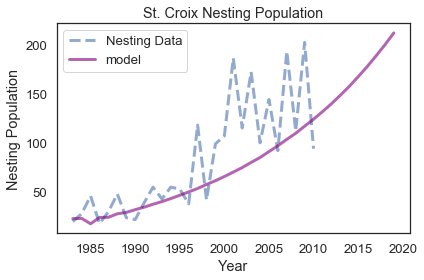

In [21]:
plt.figure(11) #plots new figure with id 11
#Plots nesting population data against simulated nesting population
plotResults(nestingTurtleData, runSimulation(system,state,stepmk1), 'St. Croix Nesting Population','purple')  
savefig('figs/Returnyearcomparisons/nestingTurtleData-ModelMk1-.png') #plots model 10 years into future

### Plotting each return interval along with new nesters
Plots the state's return interval for each year against its corresponding returning year data from St. Croix

Saving figure to file figs/Returnyearcomparisons/returnRateTurtleData-ModelMk1-1.png
Saving figure to file figs/Returnyearcomparisons/returnRateTurtleData-ModelMk1-2.png
Saving figure to file figs/Returnyearcomparisons/returnRateTurtleData-ModelMk1-3.png
Saving figure to file figs/Returnyearcomparisons/returnRateTurtleData-ModelMk1-4.png
Saving figure to file figs/Returnyearcomparisons/returnRateTurtleData-ModelMk1-5.png
Saving figure to file figs/Returnyearcomparisons/returnRateTurtleData-ModelMk1-6.png
Saving figure to file figs/Returnyearcomparisons/newNestersTurtleData-ModelMk1-10.png


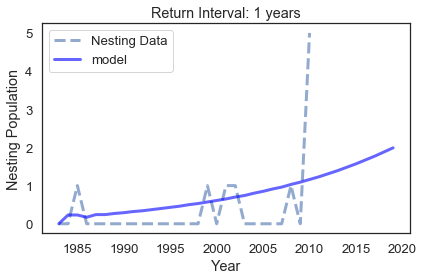

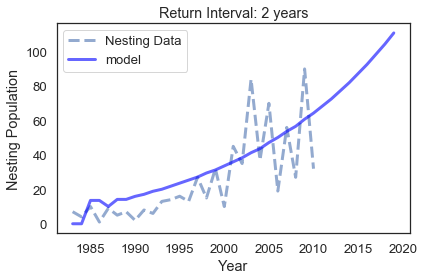

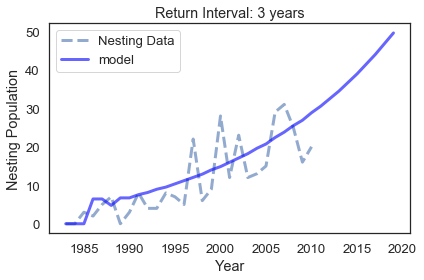

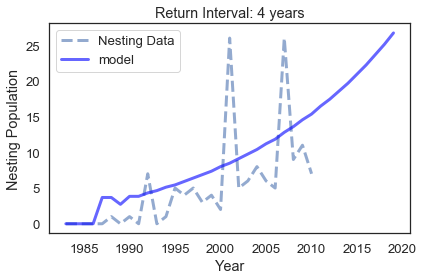

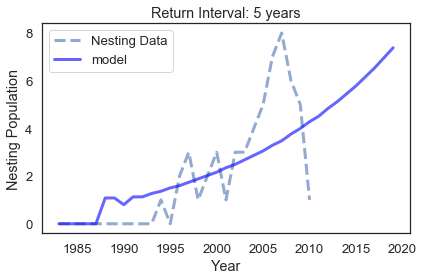

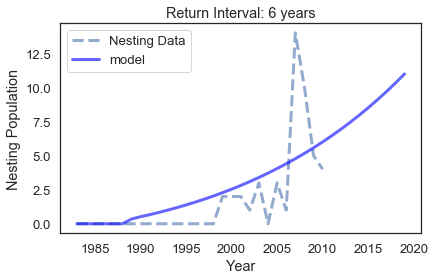

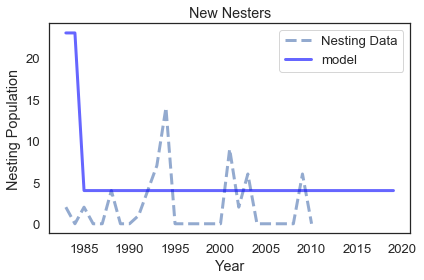

In [22]:
for num in range(1,7): #Plots six timesSeries, each of which has the nesting population for a give return interval
    plotData = 'ri' + str(num)
    stateData = 'state.r' + str(num) + 'T'
    plotTitle = 'Return Interval: ' + str(num) + ' years'
    plt.figure(num)
    plotResults(eval(plotData),eval(stateData),plotTitle,'blue')
    savefig('figs/Returnyearcomparisons/returnRateTurtleData-ModelMk1-' + str(num) + '.png')

plt.figure(10)
plotResults(new,state.newN,'New Nesters','blue')    #Plots the new nesters every year against the data
savefig('figs/Returnyearcomparisons/newNestersTurtleData-ModelMk1-10.png')

# Applying this model to the Northern Caribbean
After running this model against St. Croix, we predict that the model should also work similarly against leatherbacks nesting population in the Northern Caribbean

We redefine the starting population using the same tuned rates from the St. Croix data and compare it to nesting numbers in the Northern Caribbean, a proxy for the number of females nesting. We would have used nesting female numbers but we could not find data for that in leatherback turtles.

In [25]:
systemTest = System(nestR = .002, 
                    rr1 = .01, 
                    rr2 = .59, 
                    rr3 = .28, 
                    rr4 = .16, 
                    rr5 = .047, 
                    rr6 = .015, 
                    startYear = 1984, 
                    endYear = 2020, 
                    startPop = 200)
stateTest = State(population = 2000, 
                  r1T = TimeSeries(), 
                  r2T = TimeSeries(), 
                  r3T = TimeSeries(), 
                  r4T = TimeSeries(), 
                  r5T = TimeSeries(), 
                  r6T = TimeSeries(), 
                  newN = TimeSeries())

In [26]:
turtleDataframe2 = pandas.read_csv('data/NOAA_LeatherbackNestsData.csv',index_col = 0, header = 0)
nestsData = turtleDataframe2['Nests']

### Plotting the Northern Caribbean nesting numbers against our model created from St. Croix data

Saving figure to file figs/NewData/nestsData-ModelMk1-.png


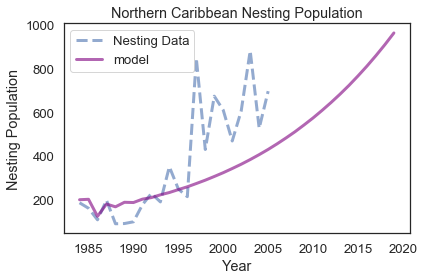

In [28]:
plotResults(nestsData, runSimulation(systemTest,stateTest,stepmk1), 'Northern Caribbean Nesting Population','purple')   #Plots nesting population data against simulated nesting population
savefig('figs/NewData/nestsData-ModelMk1-.png')